# Ask the Law: Building Legal Chatbots with AI and RAG
prepared by Jan Mizerka

# Abstract
Participants of this workshop will explore the use of large language models (LLMs) to build chatbots capable of performing semantic search in legal documents. They will be guided through the process of creating a Retrieval-Augmented Generation (RAG) model and a vector database using documents from the Polish Journal of Laws, accessed via the ISAP (Internetowy System Aktów Prawnych) API. Throughout the workshop, participants will gain hands-on experience with free tools such as Google Colab and coding primarily in Python. While programming skills are an asset, no prior experience is required. After acquiring the core techniques, participants will work on their own RAG-based projects, applying the methodology to diverse use cases. This workshop offers valuable insights into how AI and machine learning can enhance the analysis and accessibility of complex legal and social science texts.

## Additional Files and Resources

- [GitHub Repo of Jan Mizerka](https://github.com/SICSS-AMULaw/rag_workshop) – original repository with source materials
- [GitHub Repo of SICSS-AMU\Law](https://github.com/SICSS-AMULaw/Edition_2025/tree/main/Workshop/Natural%20Language%20Processing%20by%20Jan%20Mizerka) - offical website with workshop materials
- [Needed Files (Google Drive)](https://drive.google.com/drive/folders/1zc-eWI75mCHcEABmZ3TZEz1kt7z4AmKL?usp=share_link) – required data and documents


## **1. Introduction**


---

The workshop will be divided into 6 parts:



1. Introduction: complete example
2. Data Acquisition & Preparation
3. Document Parsing & Text Extraction
4. Preprocessing Data
5. Embedding and Vector Database
6. RAG & LLMs
---


Resources:
1. ISAP API - https://api.sejm.gov.pl/eli/openapi/ui/

2. pdf-marker - https://github.com/VikParuchuri/marker

3. HuggingFace - https://huggingface.co/





### 1.1 Legal Question Answering System

#### 1.2.1 Polish Journal of Laws

The Polish Journal of Laws (Dziennik Ustaw Rzeczypospolitej Polskiej, often abbreviated as Dz.U.) is the official publication of the Republic of Poland used to officially publish the most important legal acts. Once a legal act is published in the Journal of Laws, it becomes officially binding.



#### 1.2.2 Change Colab's runtime to T4 (GPU)

GPUs (Graphical-Processing-Units) are powerful computer chips originally designed to handle images and graphics, but also used extensively in AI field. They are more suitable for running AI models because they are able to run many parallel tasks at once in contrast to CPUs which can handle only a few. This way we will get LLM's responses much faster

#### 1.2.3 Create Hugging Face account

Go to: https://huggingface.co

Hugging Face is a company and open-source platform focused on natural language processing (NLP) and machine learning (ML). It provides datasets library, repository of open-source ML models and much more. The large language model we will use is in restricted access - we must first accept the terms of use in order to use it. That's why we need to create an account, accept the terms and then generate personal token to allow access to the model from Colab

#### 1.2.4 Install workshop package
Go to: [GITHUB_LINK](https://)

This is a repository we will use throught the workshop. The whole source code is available there in case you want to recreate it at home.

During the workshop we will use installed version of the package. This way will abstract away most of the code complexity and allows as to work on the higher level concepts

In [ ]:
# In Colab to use shell we need to precede a command with "!"
# pip is python's package manager which allows installing external libraries
#/content/drive/MyDrive/rag/rag
!pip install git+https://github.com/jmizerka/sicss #link.to.github_repo

#### 1.2.5 Query the system




In [ ]:
### Hugging Face login using acess token

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import json
import faiss

index_path = "path_to_faiss_index.faiss"
json_path = "path_to_json_file.json"

# Reading database with the context - Journal of Laws in a format understanble for AI Model
index = faiss.read_index(index_path)

# Reading actual documents in chunks
eng_chunks = []
with open(json_path, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)  # Convert each line of JSON text into a Python dictionary
        eng_chunks.append(data)  # Extract the 'eng_chunk' value from each line

In [ ]:
from rag.llms.models import setup_qa_pipeline
from rag.vectors.embedd import load_embedding_model

# embedding model - used to translate text to computer-readable format
embedding_model = load_embedding_model()
# Hugging Face AI model to generate answers
qa_pipeline = setup_qa_pipeline("google/gemma-2-2b-it")


In [ ]:
### EXAMPLE QUERIES
# "What is the minimum sentence for killing a man without request or contract?"
# "What is the minimum sentence for mercy killing?"
# "What is the minimal notice period for employment contract concluded for a trial period?"
# "Who can be a member of a political party in Poland"
# "Can you ran for Parliament and Senate at the same time?"
# "Who decides on the validity of elections?"

In [ ]:
from rag.llms.core import rag_search
query = "Who decides on the validity of elections?"
generation_params = {"temperature": 1, "max_new_tokens": 100}

answer = rag_search(query, index, eng_chunks, embedding_model, qa_pipeline, params=generation_params, k=3)
print("------------RAG RESPONSE-----------")
print(answer)

#### 1.2.6 Exercises

1. Experiment with different queries
2. Change context length in rag_search.HINT: help(function_name) shows documentation for the function
3. Reformulate the original query so that it conveys the same meaning in different words. Compare the answers.


## **2. Data Acquistion & Preparation**

To build a RAG first we need some documents to feed the model. In our case we will use [ISAP API](https://api.sejm.gov.pl/eli/openapi/ui/) to retrieve legal documents. ISAP (Internetowy System Aktów Prawnych) - Internet System of Legal Acts is a legal information system edited by a team of specialists at the Informatics Center of the Sejm (lower house of the Polish parliament) Chancellery.

#### 2.1 API

An API (Application Programming Interface) is a set of rules or protocols that lets different software systems communicate with each other. Think of it as a contract: it defines what data or functionality can be requested, how to ask for it, and what to expect in return.

Some more resources about APIs:
1. https://aws.amazon.com/what-is/api/
2. https://www.postman.com/what-is-an-api/
3. https://www.ibm.com/think/topics/api

In [ ]:
# API call example using python
import requests # library for handling API calls
response = requests.get('https://api.sejm.gov.pl/eli/acts/DU').json() #return response in json format
print(response)

#### 2.2 API Exercises

1. Get a list of publishers
2. Find how many acts where published in DU in 2013
3. Find the number of articles in DU 2007 pos 1
4. Find the title of the first act published in 1997 in DU.
5. Find title, type and releasing body of DU 1990 pos 8
6. Find how many acts in total where published in MP (Monitor Polski)
7. Find the first year from which MP is available
8. Find the title of the first act announced on 12th December 2020

#### 2.2 Extract documents information

##### 2.2.1 Import rag package

In [ ]:
# This is how you use external libraries in python
# first you need specify the name of the package you want to import from
# then you specify what to import

from rag.isap.info import extract_all_docs_data, filter_out_results
from rag.isap.files import get_articles
import rag

# if you don't know what exactly is in a package
# you can use help(package_name)
# it shows you a description, content as well as location of the package in your file system

help(rag)

In [ ]:
# You can also printout the whole source code of a module or function

import inspect

print(inspect.getsource(rag.isap.info))

##### 2.2.2 Run extract function

In [ ]:
help(extract_all_docs_data)

In [ ]:
docs = extract_all_docs_data()

##### 2.3 Filter the results

In [ ]:
# Get unique values for 'status'
statuses = sorted(set(doc['status'] for doc in docs))

# Get unique values for 'type'
types = sorted(set(doc['type'] for doc in docs))

# Get unique values for all 'keywords' (flattening the keyword lists from each doc)
keywords = sorted(set(keyword for doc in docs for keyword in doc['keywords']))

In [ ]:
help(filter_out_results)

In [ ]:
# skip certain documents based on simple keywords
STATUSES_TO_SKIP = ['nieobowiązujący - uchylona podstawa prawna', # not in force - legal basis repealed
                    'uchylony', 'uchylony wykazem', #repelead
                    'uznany za uchylony', # deemed repealed
                    'wydanie z naruszeniem prawa', #issued in violation of the law
                    'wygaśnięcie aktu', #expiration of the act
                    'akt jednorazowy', #one-off act
                    'Uchwała'] #resolution
TYPES_TO_SKIP=['Dokument wypowiedzenia', #Termination document
               'Instrukcja', #Instruction
               'Komunikat', #Announcement
               'Obwieszczenie', #Notice
               'Orzeczenie', #Ruling
               'Orędzie', #Message
               'Oświadczenie', #Statement
               'Postanowienie', #Order
               'Protokół', #Protocol
               'Przepisy', #Regulations
               'Przepisy wykonawcze', #Executive privision
               'Raport', #Report
               'Regulamin', #Regulations
               'Reskrypt', #Rescript
               'Sprostowanie', #Correction
               'Zarządzenie', #Order
               'Akt', #Act
               'Oświadczenie rządowe'] #Government statement

# below I use prefixes of words to filter
# it allows matching of different gramatic forms of those words
title_keywords = ['ratyfik', #ratify
                  'zmienia', # change
                  'zmian', #changes
                  'wypow', #terminate
                  'Porozumienie Administracyjne'] #Administrative Agreement
filters = {"statuses":STATUSES_TO_SKIP, "types": TYPES_TO_SKIP, "titles": title_keywords, "inForce_status": "IN_FORCE"}
filtered_docs = filter_out_results(docs, filters)



In [ ]:
filtered_docs

In [ ]:
### we need to keep only a small subset of the results for this example due to Colab's constraints
### we can filter based on keywords

keywords

In [ ]:
target_keyword = "statki powietrzne"

# for each document in filtered document keep it in the list of docs
# if target_keyword occurs in keywords
docs = [doc for doc in filtered_docs if target_keyword in doc['keywords']]
titles = [doc['title'] for doc in docs]

In [ ]:
len(titles)

#### 2.4 Download relevant documents

In [ ]:
from rag.isap.files import get_articles
help(get_articles)

In [ ]:
# download articles and save them in specified path
get_articles(docs, '/content')

#### 2.5 Exercises


1. Filter out all documents of type "Ustawa" from filter_docs
2. Filter out all documents except those with status "uchylony" (repealed)
3. Filter out all document which do not contain keywords "banki" or "bankowe" (banks, banking)
4. Filter out all documents which are in force
5. Filter out all documents which are older than 50 years
6. Using get_response function from rag.isap.helpers, get a pdf of DU 2025 1 and save it to a file. Find out in API documentation which endpoint to use. (You can also use API directly).
7. Using get_response function from rag.isap.helpers get any document in html format



## **3. Document Parsing & Text extraction**

Extracting text from PDFs is very difficult because PDF is binary format and text might be stored in a variety of different ways:
1. As a text object: you can directly identify the text, the only problem which remains is keeping the correct layout
2. As an image (scanned documents): we need OCR algoithm
3. As a vector object: we need to flatten the file to image and use OCR or use some vector shape analysis (advanced)



OCR algorithms allow computers to "read" text from images — like scanned documents, photos of signs, or handwritten notes. The goal is to convert the text in those images into machine-readable characters (like what you can copy-paste or search).

It usually involves a few steps:

1. Image preprocessing: the image is cleaned by adjusting brightness, removing noise, converting the image to black and white etc. It makes the text easier to detect

2. Text detection: the algorithm finds where the text is located in the image - identyfing lines, words or letters.

3. Character recognition: each detected character or word is compared against known patterns using trained models such as convolutional neural networks or others. It helps with recognizing letters even if they are handwritten or font varies a lot.

4. Post-procesing: once raw characters are recognized, algorithms correct errors (like mistaking a "1" for an "l") using dictionaries, grammar rules, or context.

We will use marker-pdf: https://github.com/VikParuchuri/marker

It allows for extracting text in different formats, extracting images, formats tables, forms, equations, inline math, links, references, and code blocks. You can also boost accuracy adding llm service


#### 3.1 PDF Marker

In [ ]:
# install marker-pdf - ML library for text extraction from pdfs

# pip is standard python package manager, which allows you to un/install
# external python libraries

# We need to reinstall some packages because Colab's setup conflicts
# with marker-pdf

# "!" is used in Colab to run shell commands (command line)
!pip uninstall -y torchvision torchaudio fastai
!pip install --quiet torch==2.7.0
!pip install --quiet marker-pdf

In [ ]:
# most command line tools support --help flag which explain how to use given tool
!marker_single --help

In [ ]:
!marker --help

In [ ]:
pdf_path = 'input_pdf_path'
output_dir = 'output_dir_path'
!marker_single "{pdf_path}" --output_dir="{output_dir}" --force_ocr


In [ ]:
# convert all pdfs from a folder
input_folder = "/content"
output_dir = "/content/sample_data"
!marker '{input_folder}' --workers 1 --output_dir="{output_dir}" --disable_image_extraction

#### 3.2 Extract md files

In [ ]:
from rag.txt_extract.files import extract_md_files
help(extract_md_files)

In [ ]:
input_dir = '/content/sample_data'
output_dir = '/content/sample_data'
extract_md_files(input_dir, output_dir)

#### 3.3 Filter out other languages

Some international treaties have texts in polish + some other language versions, mostly french or english. We can discard other languages because they are just translations of polish texts. We will save processing time this way

We use langdetect library for that. It is based on Google's language-detection project. It allows detection of over 50 languages. The basic idea how it works is pretty simple: each supported language have a profile build based on wikipedia source. A profile consists of a collection of n-grams -  adjacent strings of words or characters of length n in a given language and their frequencies. When we try to detect a language of a text we convert it to n-grams and compute similarity score between the profile and analyzed text. It then returns probability scores a few different languages it might belong to.  

In [ ]:
from rag.txt_extract.lang import extract_lang

def read_file(path):
    with open(path, 'r') as f:
        return f.read()
def save_file(text, path):
    with open(path, 'w') as f:
        return f.write(text)

text = read_file('path_to_input_file.md')
cleaned_text = extract_lang(text, 'pl')
save_file(cleaned_text, 'path_to_output_file.md')

#### 3.4 Discard contamination from other texts

Because the law journal is published in book format, it’s common for one text to end and another to begin on the same page. This can cause confusion when feeding the content into a model. To avoid this, we need to filter out everything before the target text begins and everything after it ends.






##### 3.4.1 Regex

Regex (short for regular expressions) is a way to describe patterns in text so you can search for, match, or extract specific pieces of information.

Think of it like a very precise and flexible search tool. Instead of searching for an exact word like "gene", you can write a pattern that matches any word that starts with "gene", like "geneA", "gene1", or "gene_variant".

For example, in a long dataset or document, you might want to:

- Find all email addresses

- Extract dates in different formats

- Identify lines that start with a number

- Replace every instance of a certain format (like changing "mm/dd/yyyy" to "yyyy-mm-dd")

Regex gives you a compact way to define these rules using special symbols. For instance:

\d means any digit

\w+ means one or more letters or numbers (a "word")

^ means the start of a line

. means any character

Regex is universal across different programming languages, difference are very small.

Regex cheat sheet: https://www.datacamp.com/cheat-sheet/regular-expresso

In [ ]:
# SEARCH
import re

text = "he Regional Veterinary Authority shall repeal the Regulation as soon as the risk of an infectious disease which is subject to control or eradication has ceased"

if re.search(r'\bRegulation\b', text):
    print("reference to Regulation found")
else:
    print("No reference to Regulation found")


In [ ]:
#MATCH
citation = "Dz.U. 2004 nr 69 poz. 625"

if re.match(r'Dz.U. \d{4} nr \d+ poz. \d+', citation):
    print("Valid citation")
else:
    print("Invalid citation.")

In [ ]:
#REPLACE
import re

text = "In the matter of John Doe vs. Jane Doe, the court ruled..."

redacted = re.sub(r'\b(John|Jane) Doe\b', '[REDACTED]', text)
print(redacted)


In [ ]:
#FIND ALL

text = """
On March 14, 2023, pursuant to Section 4 of the Civil Code, Plaintiff filed Complaint No. 2023-CV-005789 in the Superior Court of California. The property in dispute, located at 2456 Elm Street, was purchased on May 22, 2015, for $475,000. According to Paragraph 12 of Lease Agreement #9847321, the tenant was obligated to pay monthly rent of $2,350 beginning on June 1, 2018. However, as of January 31, 2023, the Defendant had accumulated $18,800 in unpaid rent over a span of 8 months.
"""

# Extract all numbers, including ones with commas
numbers = re.findall(r'\d[\d,]*', text)
print(numbers)

##### 3.4.2 Run discard functions

In [ ]:
from rag.txt_extract.discard import remove_after, remove_before


In [ ]:
help(remove_before)

In [ ]:
help(remove_after)

#### 3.4.3 Strip markdown

As I mentioned before pdf-marker extracts texts in markdown format, so they contain some additional symbols and markdown syntaxt which we do not want to feed into a model

In [ ]:
from rag.txt_extract.discard import strip_markdown

In [ ]:
help(strip_markdown)

#### 3.5 Convert tables to comma-separated values format (CSV)

Pdf-marker extracts tables as text tables. Sometimes they might be improproperly formatted or just huge and introduce a lot of unnecessary characters. Simple approach I came up with is to convert them to comma-separated values. This way they can be easily converted back into tables if necessary but are much more compressed

In [ ]:
from rag.txt_extract.tables import detect_markdown_table, markdown_table_to_csv

In [ ]:
help(detect_markdown_table)

In [ ]:
help(markdown_table_to_csv)

##### 3.6 Processing pipeline

In [ ]:
from rag.txt_extract.files import process_documents

In [ ]:
help(process_documents)

In [ ]:
remove_after_params = {
    "default_ending": "wchodzi w życie",
    "start_pattern":r'^\s*#{2,3}\s*(USTAWA|ROZPORZĄDZENIE|OBWIESZCZENIE)',
    "signature_patterns":[
        r'Prezes Rady Ministr[oó]w:', # Prime Minister
        r'Minister [A-ZĄĆĘŁŃÓŚŹŻa-ząćęłńóśźż\s]+:', # Any Minister
        r'Prezydent Rzeczypospolitej Polskiej:', # President of Poland
        r'Marsza[łl]ek (?:Sejmu|Senatu):' # Marshal of the Sejm/Senate
    ]

}

In [ ]:
process_documents(docs, "/content/sample_data/mds","/content/sample_data", remove_after_params)

#### 3.7 Exercises
1. Compare accuracy of langdetect on single words of your native language vs whole sentences
2. Return probabilities along with detected languages (HINT: use help())
3. Extract images from any document using pdf-marker
4. Extract only 1st and 2nd page from any document
5. Change output format to html or json
6. Force object character recognition on a whole document
7. "Plaintiff SSN: 123-45-6789; Defendant SSN: 987-65-4321." - replace social security numbers in the text with \[REDACTED\]
8. "See 410 U.S. 113 and 347 U.S. 483 for landmark rulings." - find all citations of a form XXX U.S. XXX
9. "Violations include Penal Code § 187: Murder, and Penal Code § 211: Robbery." - extract statute number with description HINT: use \(\) to capture text for extraction
10. Modify threshold parameter for remove_before function and check how it affects the results

## **4. Preprocessing**

We managed to extract texts of legal acts from pdfs. Now we need to preprocess those texts. Methods of preprocessing largely depend on the problem at hand.

#### 4.1 Chunking

Before embedding we need to divide documents into smaller portions called chunks. This is done primarly because of context window limit in most models but also it helps accurately represent meaning - long unfocused blocks of text tend to dillute meaning. Chunking is also more efficient during retrieval

In [ ]:
from rag.preprocess.chunk import chunk_by_sections, fallback_chunk

In [ ]:
help(chunk_by_sections)

In [ ]:
sections_patterns = [r'(Article\s+\d+)', r'(Art\.\s*\d+)', r'(§+\s*\d+)']
chunk_by_sections(text, sections_patterns)

In [ ]:
help(fallback_chunk)

In [ ]:
from rag.preprocess.core import process_folder
help(process_folder)


#### 4.2 Translation

Due to the fact that all documents are written in polish I decided to translate all of them. I used Libre Translate, which is open source translation tool, set up locally on my machine. Instruction how to set it up you can find here: https://github.com/LibreTranslate/LibreTranslate. For now we will use free google API: https://lingva.ml/ because it doesn't have to be installed locally.

In [ ]:
# CTRL + M, then I to stop

from rag.preprocess.translate import show_ui

show_ui()

#### 4.3 Exercises

1. Chunk any text using fallback_chunk fuction. Change chunk length to 500 characters
2. Chunk any text using fallback_chunk fuction. Change chunk overlap to 50 characters.
3. Process the document of your choice
4. Create at least 1 more regex pattern for section extraction

5. Using lingva.ml translation endpoint: https://lingva.ml/api/v1/{source}/{target}/{text}:
    - Translate any text from polish to english
    - Translate any text from english to polish
    - Translate 10 texts using a loop : https://wiki.python.org/moin/ForLoop (HINT:  you need requests library)

## **5. Embedding and Vector Databases**

Computers don’t understand language or concepts like humans do. They only understand numbers. So, if we want a computer to understand texts and find patterns in them we need to translate them into numbers first.

Embeddings are mathematical representations of data, typically in the form of vectors—arrays of numbers—that capture the essential characteristics or meaning of the data.

For example, words, sentences, images, or scientific measurements can be represented as points in a high-dimensional space (think of it as a coordinate system with many axes).

How do embeddings work?
Each data point (a word, sentence, etc.) is mapped to a vector in a continuous vector space.

The position of each vector is learned so that similar data points are close together, and dissimilar ones are far apart.

The number of dimensions (length of the vector) is usually fixed (e.g., 100, 300, 768), balancing expressiveness and computational efficiency.

Embeddings are generated by training models on large datasets where the model learns to place similar items close to each other based on context or features.Those features usually are not human-interpretable



Additonal resources:
1. https://www.pinecone.io/learn/vector-embeddings/
2. https://www.elastic.co/what-is/vector-embedding

#### 5.1 Embedding

For embedding we use all-MiniLM-L6-v2 model: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2. It's relatively small model (22.7M parameters) which maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

The model was trained on large dataset of sentences using self-supervised contrastive learning objective: it was fed pairs of sentences with similar meanings and the model given a sentence from the pair had to predict which out of a set of randomly sampled other sentences was actually paired with it in the dataset.



##### 5.1.1 Simple example: Fruits embedding

In [ ]:
import numpy as np

# Each vector = [sweetness, sourness, crunchiness, shape]
fruit_vectors = {
    'apple':    np.array([4, 2, 5, 1]),
    'banana':   np.array([5, 1, 1, 5]),
    'lemon':    np.array([1, 5, 1, 2]),
    'carrot':   np.array([3, 2, 4, 4]),
}

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2) #multiple vectors
    norm1 = np.linalg.norm(vec1) # length of vec1
    norm2 = np.linalg.norm(vec2) # length of vec2
    return dot_product / (norm1 * norm2)

def find_most_similar(fruit, vectors):
    target_vec = vectors[fruit]
    similarities = {}
    for other_fruit, vec in vectors.items():
        if other_fruit != fruit:
            sim = cosine_similarity(target_vec, vec)
            print(f"Similarity between {fruit} and {other_fruit}: {sim:.4f}")
            similarities[other_fruit] = sim
    most_similar = max(similarities, key=similarities.get)
    return most_similar, similarities[most_similar]

closest_fruit, similarity = find_most_similar('apple', fruit_vectors)
print(f"\nThe fruit most similar to 'apple' is '{closest_fruit}' with similarity {similarity:.4f}")


In [ ]:
from rag.vectors.embedd import embed_texts
help(embed_texts)

#### 5.2 Vector database

For storing the embeddings we use Faiss index. FAISS (Facebook AI Similarity Search) is a library developed by Facebook to quickly search for similar items in large collections of high-dimensional vectors — like those produced by machine learning models.

A FAISS index is a data structure that can store vectors in a way that makes similarity search much faster than just checking one-by-one. Depending on the type of index, FAISS can:
- Compress vectors to use less memory
- Use clever math (like clustering or trees) to quickly rule out most vectors

We use basic index which in fact uses brute-force approach: checks a distance between each pair of vectors. Our dataset is small enough so it still happens fast


In [ ]:
from rag.vectors.index import read_faiss_index, save_faiss_index, create_faiss_index

In [ ]:
help(read_faiss_index)

In [ ]:
help(create_faiss_index)

In [ ]:
help(save_faiss_index)

In [ ]:
import json
import faiss

index_path = "path_to_faiss_index.faiss"
json_path = "path_to_json_file.json"

# Reading database with the context - Journal of Laws in a format understanble for AI Model
index = faiss.read_index(index_path)

# Reading actual documents in chunks
eng_chunks = []
with open(json_path, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)  # Convert each line of JSON text into a Python dictionary
        eng_chunks.append(data)  # Extract the 'eng_chunk' value from each line


## **6. RAG & LLMs**




#### 6.1 What is RAG?

RAG, which stands for Retrieval-Augmented Generation is AI framework which combines more traditional approaches to information retrieval (databases) with Large Language Models.

One of the main drawbacks of large language models is their tendency to hallucinate—that is, generate plausible-sounding but incorrect or fabricated information. This limits their reliability in contexts where factual accuracy is critical, such as information retrieval. Retrieval-Augmented Generation (RAG) is a technique designed to mitigate this issue by supplementing the model’s input with relevant external context.

RAG works by retrieving relevant text passages from a vector database, which stores embeddings (numerical representations) of documents. These embeddings allow for semantic similarity comparisons. When a query is issued, its embedding is compared to those in the database—often using cosine similarity—to find the most relevant passages. These passages are then injected into the model prompt to ground the model’s response in retrieved evidence, thereby improving factual accuracy.

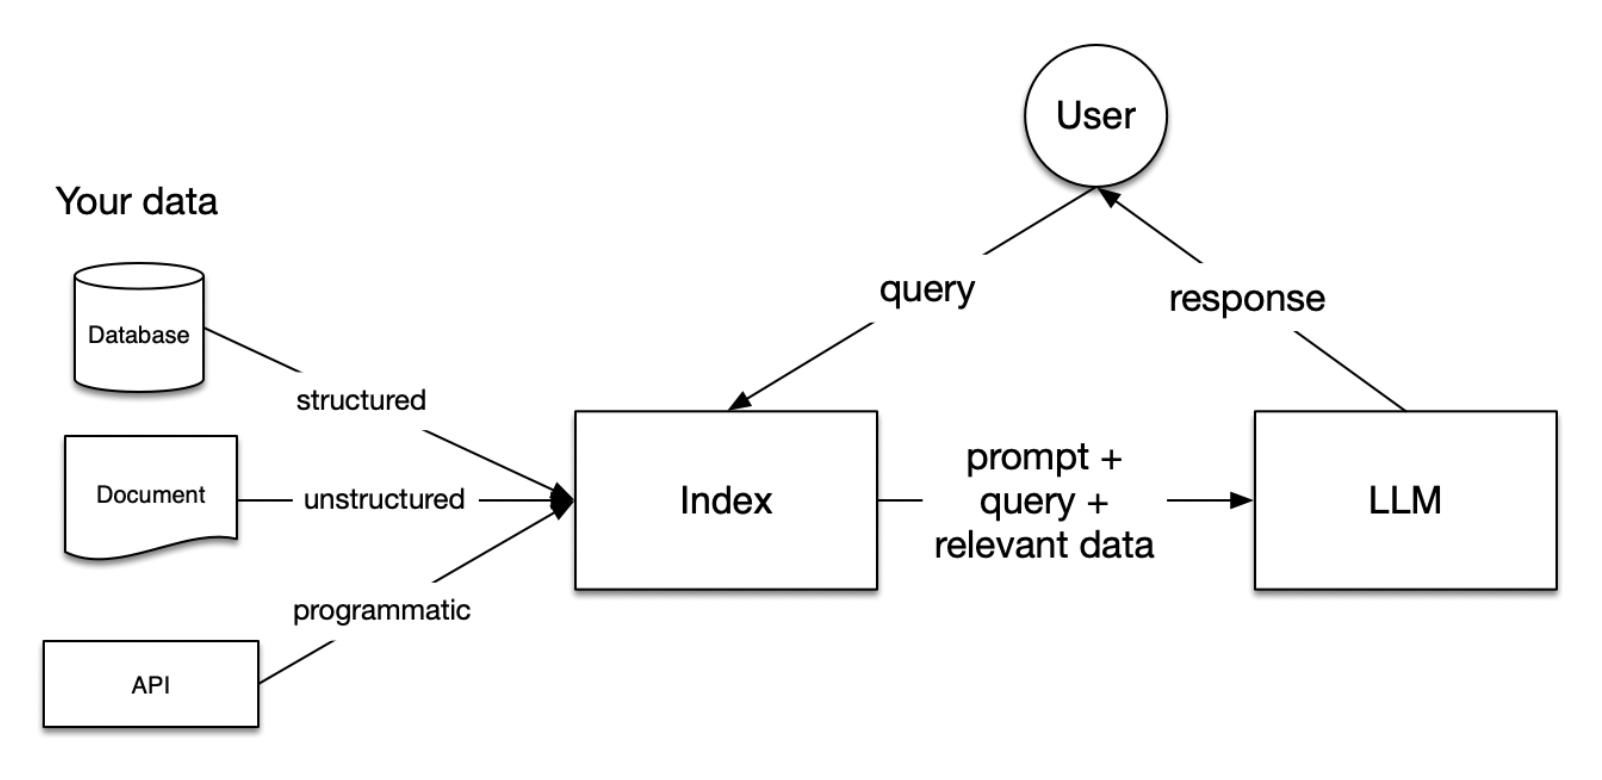

Source: https://codingscape.com/blog/rag-101-what-is-rag-and-why-does-it-matter

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from rag.vectors.embedd import load_embedding_model
from rag.llms.models import setup_qa_pipeline

In [ ]:
help(load_embedding_model)

In [ ]:
embedding_model = load_embedding_model()

In [ ]:
help(setup_qa_pipeline)

In [ ]:
qa_pipeline = setup_qa_pipeline()

In [ ]:
# optional parameters for the text generation
#generation_params = {"temperature": 1.0, "max_new_tokens": 150, "do_sample": True}

In [ ]:
from rag.llms.core import rag_search
query = "what is the minimal punishment for murder"
# optional parameters for the text generation
#generation_params = {"temperature": 1.0, "max_new_tokens": 150, "do_sample": True}
answer = rag_search(query, index, eng_chunks, embedding_model, qa_pipeline, generation_params)
print("------------RAG RESPONSE-----------")
print(answer)

#### Exercises

1. Send a blank system prompt. See how it affects the results
2. Modify the system prompt so that the model returns “No information in the context” when the question cannot be answered based on the context provided.
3. Try to make the model ignore the system prompt
4. Use a regular qa_pipeline with the same prompt as for RAG. Compare the results (HINT: check transformers documentation)
5. Modify the temperature parameter. See how it affects the results
6. Run several queries with different values of the *temperature* parameter and try to find out how it affects the result
7. Analyze how different values of max_new_tokens affect the result